# 🚀 Snorkel Intro Tutorial: Data Labeling

In this tutorial, we will walk through the process of using Snorkel to build a training set for classifying YouTube comments as spam or not spam.
The goal of this tutorial is to illustrate the basic components and concepts of Snorkel in a simple way, but also to dive into the actual process of iteratively developing real applications in Snorkel.

* For an overview of Snorkel, visit [snorkel.org](https://snorkel.org)
* You can also check out the [Snorkel API documentation](https://snorkel.readthedocs.io/)

Our goal is to train a classifier over the comment data that can predict whether a comment is spam or not spam.
We have access to a large amount of *unlabeled data* in the form of YouTube comments with some metadata.
In order to train a classifier, we need to label our data, but doing so by hand for real world applications can be prohibitively slow and expensive, often taking person-weeks or months.

We therefore turn to weak supervision using **_labeling functions (LFs)_**: noisy, programmatic rules and heuristics that assign labels to unlabeled training data.
We'll dive into the Snorkel API and how we write labeling functions later in this tutorial, but as an example,
we can write an LF that labels data points with `"http"` in the comment text as spam since many spam
comments contain links:

```python
from snorkel.labeling import labeling_function

@labeling_function()
def lf_contains_link(x):
    # Return a label of SPAM if "http" in comment text, otherwise ABSTAIN
    return SPAM if "http" in x.text.lower() else ABSTAIN
```

The tutorial is divided into four parts:
1. **Loading Data**: We load a [YouTube comments dataset](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/), originally introduced in ["TubeSpam: Comment Spam Filtering on YouTube"](https://ieeexplore.ieee.org/document/7424299/), ICMLA'15 (T.C. Alberto, J.V. Lochter, J.V. Almeida).

2. **Writing Labeling Functions**: We write Python programs that take as input a data point and assign labels (or abstain) using heuristics, pattern matching, and third-party models.

3. **Combining Labeling Function Outputs with the Label Model**: We use the outputs of the labeling functions over the training set as input to the label model, which assigns probabilistic labels to the training set.

4. **Training a Classifier**: We train a classifier that can predict labels for *any* YouTube comment (not just the ones labeled by the labeling functions) using the probabilistic training labels from step 3.

### Task: Spam Detection

We use a [YouTube comments dataset](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/) that consists of YouTube comments from 5 videos. The task is to classify each comment as being

* **`HAM`**: comments relevant to the video (even very simple ones), or
* **`SPAM`**: irrelevant (often trying to advertise something) or inappropriate messages

For example, the following comments are `SPAM`:

        "Subscribe to me for free Android games, apps.."

        "Please check out my vidios"

        "Subscribe to me and I'll subscribe back!!!"

and these are `HAM`:

        "3:46 so cute!"

        "This looks so fun and it's a good song"

        "This is a weird video."

### Data Splits in Snorkel

We split our data into 4 sets:
* **Training Set**: The largest split of the dataset, and the one without ground truth ("gold") labels.
We will generate labels for these data points with weak supervision.
* \[Optional\] **Development Set**: A small labeled subset of the training data (e.g. 100 points) to guide LF development. See note below.
* **Validation Set**: A small labeled set used to tune hyperparameters while training the classifier.
* **Test Set**: A labeled set for final evaluation of our classifier. This set should only be used for final evaluation, _not_ error analysis.


While it is possible to develop labeling functions on the unlabeled training set only, users often find it more time-efficient to label a small dev set to provide a quick approximate signal on the accuracies and failure modes of their LFs (rather than scrolling through training data points and mentally assessing approximate accuracy).
Alternatively, users sometimes will have the validation set also serve as the development set.
Do the latter only with caution: because the labeling functions will be based on data points from the validation set, the validation set will no longer be an unbiased proxy for the test set.

## 1. Loading Data

We load the YouTube comments dataset and create Pandas DataFrame objects for the train, validation, and test sets.
DataFrames are extremely popular in Python data analysis workloads, and Snorkel provides native support
for several DataFrame-like data structures, including Pandas, Dask, and PySpark.
For more information on working with Pandas DataFrames, see the [Pandas DataFrame guide](https://pandas.pydata.org/pandas-docs/stable/getting_started/dsintro.html).

Each DataFrame consists of the following fields:
* **`author`**: Username of the comment author
* **`data`**: Date and time the comment was posted
* **`text`**: Raw text content of the comment
* **`label`**: Whether the comment is `SPAM` (1), `HAM` (0), or `UNKNOWN/ABSTAIN` (-1)
* **`video`**: Video the comment is associated with

We start by loading our data.
The `load_spam_dataset()` method downloads the raw CSV files from the internet, divides them into splits, converts them into DataFrames, and shuffles them.
As mentioned above, the dataset contains comments from 5 of the most popular YouTube videos during a period between 2014 and 2015.
* The first four videos' comments are combined to form the `train` set. This set has no gold labels.
* The `dev` set is a random sample of 200 data points from the `train` set with gold labels added.
* The fifth video is split 50/50 between a validation set (`valid`) and `test` set.

This next cell takes care of some notebook-specific housekeeping.
You can ignore it.

In [1]:
%matplotlib inline

import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("spam")

# Turn off TensorFlow logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# For reproducibility
os.environ["PYTHONHASHSEED"] = "0"

If you want to display all comment text untruncated, change `DISPLAY_ALL_TEXT` to `True` below.

In [2]:
import pandas as pd


DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

This next cell makes sure a spaCy English model is downloaded.
If this is your first time downloading this model, restart the kernel after executing the next cell.

In [3]:
# Download the spaCy english model
! python -m spacy download en_core_web_sm

You should consider upgrading via the 'pip install --upgrade pip' command.


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
from utils import load_spam_dataset

df_train, df_dev, df_valid, df_test = load_spam_dataset()

# We pull out the label vectors for ease of use later
Y_dev = df_dev.label.values
Y_valid = df_valid.label.values
Y_test = df_test.label.values

Let's view 5 data points from the `dev` set.

In [5]:
df_dev.sample(5, random_state=3)

,author,date,text,label,video
128,Pepe The Meme King,2015-05-19T03:49:29.427000,everyday I&#39;m shufflin﻿,0,3
151,Melissa Erhart,NaN,Check out this playlist on YouTube:chcfcvzfzfb...,1,4
31,Angel,2014-11-02T17:27:09,"Hi there~I'm group leader of Angel, a rookie K...",1,1
29,Sandeep Singh,2015-05-23T17:51:58.957000,Charlie from LOST﻿,0,4
237,BigBird Larry,2015-05-24T09:48:00.835000,Every single one of his songs brings me back t...,0,4


The class distribution varies slightly between `SPAM` and `HAM`, but they're approximately class-balanced.
You can verify this by looking at the `dev` set labels.

In [6]:
# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
ABSTAIN = -1
HAM = 0
SPAM = 1

print(f"Dev SPAM frequency: {100 * (df_dev.label.values == SPAM).mean():.1f}%")

Dev SPAM frequency: 54.0%


## 2. Writing Labeling Functions (LFs)

### A gentle introduction to LFs

**Labeling functions (LFs) help users encode domain knowledge and other supervision sources programmatically.**

LFs are heuristics that take as input a data point and either assign a label to it (in this case, `HAM` or `SPAM`) or abstain (don't assign any label). Labeling functions can be *noisy*: they don't have perfect accuracy and don't have to label every data point.
Moreover, different labeling functions can overlap (label the same data point) and even conflict (assign different labels to the same data point). This is expected, and we demonstrate how we deal with this later.

Because their only requirement is that they map a data point a label (or abstain), they can wrap a wide variety of forms of supervision. Examples include, but are not limited to:
* *Keyword searches*: looking for specific words in a sentence
* *Pattern matching*: looking for specific syntactical patterns
* *Third-party models*: using an pre-trained model (usually a model for a different task than the one at hand)
* *Distant supervision*: using external knowledge base
* *Crowdworker labels*: treating each crowdworker as a black-box function that assigns labels to subsets of the data

### Recommended practice for LF development

Typical LF development cycles include multiple iterations of ideation, refining, evaluation, and debugging.
A typical cycle consists of the following steps:

1. Look at examples to generate ideas for LFs
1. Write an initial version of an LF
1. Spot check its performance by looking at its output on data points in the training set (or development set if available)
1. Refine and debug to improve coverage or accuracy as necessary

Our goal for LF development is to create a high quality set of training labels for our unlabeled dataset,
not to label everything or directly create a model for inference using the LFs.
The training labels are used to train a separate discriminative model (in this case, one which just uses the comment text) in order to generalize to new, unseen data points.
Using this model, we can make predictions for data points that our LFs don't cover.

We'll walk through the development of two LFs using basic analysis tools in Snorkel, then provide a full set of LFs that we developed for this tutorial.

### a) Exploring the development set for initial ideas

We'll start by looking at 20 random data points from the `train` set to generate some ideas for LFs.

In [7]:
df_train[["author", "text", "video"]].sample(20, random_state=2)

,author,text,video
4,ambareesh nimkar,"""eye of the tiger"" ""i am the champion"" seems l...",2
87,pratik patel,"mindblowing dance.,.,.superbbb song﻿",3
14,RaMpAgE420,Check out Berzerk video on my channel ! :D,4
80,Jason Haddad,"Hey, check out my new website!! This site is a...",1
104,austin green,Eminem is my insperasen and fav﻿,4
305,M.E.S,hey guys look im aware im spamming and it piss...,4
22,John Monster,Οh my god ... Roar is the most liked video at ...,2
338,Alanoud Alsaleh,I started hating Katy Perry after finding out ...,2
336,Leonardo Baptista,http://www.avaaz.org/po/petition/Youtube_Corpo...,1
143,UKz DoleSnacher,Remove This video its wank﻿,1


One dominant pattern in the comments that look like spam is the use of the phrase "check out" (e.g. "check out my channel").
Let's start with that.

### b) Writing an LF to identify spammy comments that use the phrase "check out"

Labeling functions in Snorkel are created with the
[`@labeling_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html).
The [decorator](https://realpython.com/primer-on-python-decorators/) can be applied to _any Python function_ that returns a label for a single data point.

Let's start developing an LF to catch instances of commenters trying to get people to "check out" their channel, video, or website.
We'll start by just looking for the exact string `"check out"` in the text, and see how that compares to looking for just `"check"` in the text.
For the two versions of our rule, we'll write a Python function over a single data point that express it, then add the decorator.

In [8]:
from snorkel.labeling import labeling_function


@labeling_function()
def check(x):
    return SPAM if "check" in x.text.lower() else ABSTAIN


@labeling_function()
def check_out(x):
    return SPAM if "check out" in x.text.lower() else ABSTAIN

To apply one or more LFs that we've written to a collection of data points, we use an
[`LFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFApplier.html).
Because our data points are represented with a Pandas DataFrame in this tutorial, we use the
[`PandasLFApplier`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html).
Correspondingly, a single data point `x` that's passed into our LFs will be a [Pandas `Series` object](https://pandas.pydata.org/pandas-docs/stable/reference/series.html).

It's important to note that these LFs will work for any object with an attribute named `text`, not just Pandas objects.
Snorkel has several other appliers for different data point collection types which you can browse in the [API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

The output of the `apply(...)` method is a ***label matrix***, a fundamental concept in Snorkel.
It's a NumPy array `L` with one column for each LF and one row for each data point, where `L[i, j]` is the label that the `j`th labeling function output for the `i`th data point.
We'll create one label matrix for the `train` set and one for the `dev` set.

In [9]:
from snorkel.labeling import PandasLFApplier

lfs = [check_out, check]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)

  0%|          | 0/1586 [00:00<?, ?it/s]

100%|██████████| 1586/1586 [00:00<00:00, 34791.66it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 25102.06it/s]

In [10]:
L_train

array([[-1, -1],
       [-1, -1],
       [-1,  1],
       ...,
       [ 1,  1],
       [-1,  1],
       [ 1,  1]])

### c) Evaluate performance on training and development sets

We can easily calculate the coverage of these LFs (i.e., the percentage of the dataset that they label) as follows:

In [11]:
coverage_check_out, coverage_check = (L_train != ABSTAIN).mean(axis=0)
print(f"check_out coverage: {coverage_check_out * 100:.1f}%")
print(f"check coverage: {coverage_check * 100:.1f}%")

check_out coverage: 21.4%
check coverage: 25.8%


Lots of statistics about labeling functions &mdash; like coverage &mdash; are useful when building any Snorkel application.
So Snorkel provides tooling for common LF analyses using the
[`LFAnalysis` utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LFAnalysis.html).
We report the following summary statistics for multiple LFs at once:

* **Polarity**: The set of unique labels this LF outputs (excluding abstains)
* **Coverage**: The fraction of the dataset the LF labels
* **Overlaps**: The fraction of the dataset where this LF and at least one other LF label
* **Conflicts**: The fraction of the dataset where this LF and at least one other LF label and disagree
* **Correct**: The number of data points this LF labels correctly (if gold labels are provided)
* **Incorrect**: The number of data points this LF labels incorrectly (if gold labels are provided)
* **Empirical Accuracy**: The empirical accuracy of this LF (if gold labels are provided)

For *Correct*, *Incorrect*, and *Empirical Accuracy*, we don't want to penalize the LF for data points where it abstained.
We calculate these statistics only over those data points where the LF output a label.
Since we have labels for the `dev` set but not the `train` set, we'll compute these statistics for the `dev` set only by supplying `Y_dev`.

In [12]:
from snorkel.labeling import LFAnalysis

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.214376,0.0


In [13]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
check_out,0,[1],0.22,0.22,0.0,22,0,1.000000
check,1,[1],0.30,0.22,0.0,29,1,0.966667


So even these very simple rules do quite well!
We might want to pick the `check` rule, since both have high precision and `check` has higher coverage.
But let's look at our data to be sure.

The helper method `get_label_buckets(...)` groups data points by their predicted label and true label.
For example, we can find the indices of data points that the LF labeled `SPAM` that actually belong to class `HAM`.
This may give ideas for where the LF could be made more specific.

In [14]:
from snorkel.analysis import get_label_buckets

buckets = get_label_buckets(Y_dev, L_dev[:, 1])
df_dev.iloc[buckets[(HAM, SPAM)]]

,author,date,text,label,video
260,Eanna Cusack,2014-01-20T22:20:59,Im just to check how much views it has﻿,0,1


There's only one row here because `check` produced only one false positive on the `dev` set.
Now let's take a look at 10 random `train` set data points where `check` labeled `SPAM` to see if it matches our intuition or if we can identify some false positives.

In [15]:
df_train.iloc[L_train[:, 1] == SPAM].sample(10, random_state=1)

,author,date,text,label,video
305,M.E.S,NaN,hey guys look im aware im spamming and it piss...,-1.0,4
265,Kawiana Lewis,2015-02-27T02:20:40.987000,Check out this video on YouTube:opponents mm <...,-1.0,3
89,Stricker Stric,NaN,eminem new song check out my videos,-1.0,4
147,TheGenieBoy,NaN,check out fantasy music right here -------&...,-1.0,4
240,Made2Falter,2014-09-09T23:55:30,"Check out our vids, our songs are awesome! And...",-1.0,2
273,Artady,2014-08-11T16:27:55,https://soundcloud.com/artady please check my ...,-1.0,2
94,Nick McGoldrick,2014-10-27T13:19:06,Check out my drum cover of E.T. here! thanks -...,-1.0,2
139,MFkin PRXPHETZ,2014-01-20T09:08:39,"if you like raw talent, raw lyrics, straight r...",-1.0,1
303,이 정훈,NaN,"This great Warning will happen soon. ,0\nLneaD...",-1.0,4
246,media.uploader,NaN,Check out my channel to see Rihanna short mix ...,-1.0,4


No clear false positives here, but many look like they could be labeled by `check_out` as well.
Let's see 10 data points where `check_out` abstained, but `check` labeled.

In [16]:
buckets = get_label_buckets(L_train[:, 0], L_train[:, 1])
df_train.iloc[buckets[(ABSTAIN, SPAM)]].sample(10, random_state=1)

,author,date,text,label,video
403,ownpear902,2014-07-22T18:44:36.299000,check it out free stuff for watching videos an...,-1.0,3
256,PacKmaN,2014-11-05T21:56:39,check men out i put allot of effort into my mu...,-1.0,1
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
282,CronicleFPS,2014-11-06T03:10:26,Check me out I'm all about gaming ﻿,-1.0,1
352,MrJtill0317,NaN,┏━━━┓┏┓╋┏┓┏━━━┓┏━━━┓┏┓╋╋┏┓ ┃┏━┓┃┃┃╋┃┃┃┏━┓┃┗┓┏...,-1.0,4
161,MarianMusicChannel,2014-08-24T03:57:52,"Hello! I'm Marian, I'm a singer from Venezuela...",-1.0,2
270,Kyle Jaber,2014-01-19T00:21:29,Check me out! I'm kyle. I rap so yeah ﻿,-1.0,1
292,Soundhase,2014-08-19T18:59:38,Hi Guys! check this awesome EDM &amp; House mi...,-1.0,2
179,Nerdy Peach,2014-10-29T22:44:41,Hey! I'm NERDY PEACH and I'm a new youtuber an...,-1.0,2
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1


Most of these seem like small modifications of "check out", like "check me out" or "check it out".
Can we get the best of both worlds?

### d) Balance accuracy and coverage

Let's see if we can use regular expressions to account for modifications of "check out" and get the coverage of `check` plus the accuracy of `check_out`.

In [17]:
import re


@labeling_function()
def regex_check_out(x):
    return SPAM if re.search(r"check.*out", x.text, flags=re.I) else ABSTAIN

Again, let's generate our label matrices and see how we do.

In [18]:
lfs = [check_out, check, regex_check_out]

applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)

  0%|          | 0/1586 [00:00<?, ?it/s]

100%|██████████| 1586/1586 [00:00<00:00, 25054.20it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 18696.19it/s]

In [19]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
check_out,0,[1],0.214376,0.214376,0.0
check,1,[1],0.257881,0.233922,0.0
regex_check_out,2,[1],0.233922,0.233922,0.0


In [20]:
LFAnalysis(L_dev, lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
check_out,0,[1],0.22,0.22,0.0,22,0,1.000000
check,1,[1],0.30,0.29,0.0,29,1,0.966667
regex_check_out,2,[1],0.29,0.29,0.0,29,0,1.000000


We've split the difference in `train` set coverage, and increased our accuracy on the `dev` set to 100%!
This looks promising.
Let's verify that we corrected our false positive from before.

In [21]:
buckets = get_label_buckets(L_dev[:, 1], L_dev[:, 2])
df_dev.iloc[buckets[(SPAM, ABSTAIN)]]

,author,date,text,label,video
260,Eanna Cusack,2014-01-20T22:20:59,Im just to check how much views it has﻿,0,1


To understand the coverage difference between `check` and `regex_check_out`, let's take a look at 10 data points from the `train` set.
Remember: coverage isn't always good.
Adding false positives will increase coverage.

In [22]:
buckets = get_label_buckets(L_train[:, 1], L_train[:, 2])
df_train.iloc[buckets[(SPAM, ABSTAIN)]].sample(10, random_state=1)

,author,date,text,label,video
16,zhichao wang,2013-11-29T02:13:56,i think about 100 millions of the views come f...,-1.0,1
99,Santeri Saariokari,2014-09-03T16:32:59,"Hey guys go to check my video name ""growtopia ...",-1.0,2
21,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,-1.0,1
239,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,-1.0,1
288,Kochos,2014-01-20T17:08:37,i check back often to help reach 2x10^9 views ...,-1.0,1
65,by.Ovskiy,2014-10-13T17:09:46,"Rap from Belarus, check my channel:)﻿",-1.0,2
196,Angek95,2014-11-03T22:28:56,"Check my channel, please!﻿",-1.0,1
333,FreexGaming,2014-10-18T08:12:26,want to win borderlands the pre-sequel? check ...,-1.0,2
167,Brandon Pryor,2014-01-19T00:36:25,I dont even watch it anymore i just come here ...,-1.0,1
266,Zielimeek21,2013-11-28T21:49:00,I'm only checking the views﻿,-1.0,1


Most of these are SPAM, but a good number are false positives.
**To keep precision high (while not sacrificing much in terms of coverage), we'd choose our regex-based rule.**

### e) Writing an LF that uses a third-party model

The LF interface is extremely flexible, and can wrap existing models.
A common technique is to use a commodity model trained for other tasks that are related to, but not the same as, the one we care about.

For example, the [TextBlob](https://textblob.readthedocs.io/en/dev/index.html) tool provides a pretrained sentiment analyzer. Our spam classification task is not the same as sentiment classification, but it turns out that `SPAM` and `HAM` comments have different distributions of sentiment scores.
We'll focus on writing LFs for `HAM`, since we identified `SPAM` comments above.

**A brief intro to `Preprocessor`s**

A [Snorkel `Preprocessor`](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.Preprocessor.html#snorkel.preprocess.Preprocessor)
is constructed from a black-box Python function that maps a data point to a new data point.
`LabelingFunction`s can use `Preprocessor`s, which lets us write LFs over transformed or enhanced data points.
We add the [`@preprocessor(...)` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.preprocessor.html)
to preprocessing functions to create `Preprocessor`s.
`Preprocessor`s also have extra functionality, such as memoization
(i.e. input/output caching, so it doesn't re-execute for each LF that uses it).

We'll start by creating a `Preprocessor` that runs `TextBlob` on our comments, then extracts the polarity and subjectivity scores.

In [23]:
from snorkel.preprocess import preprocessor
from textblob import TextBlob


@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

We can use a preprocessor on its own as well.
In order to see how we should use TextBlob scores in an LF, let's see how the distributions differ for `SPAM` and `HAM`.

We'll have to tune the output of our LFs based on the TextBlob scores.
Tuning input parameters or thresholds from model outputs is a common practice in developing LFs.

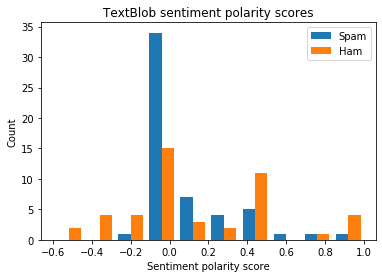

In [24]:
import matplotlib.pyplot as plt

spam_polarities = [
    textblob_sentiment(x).polarity for _, x in df_dev.iterrows() if x.label == SPAM
]

ham_polarities = [
    textblob_sentiment(x).polarity for _, x in df_dev.iterrows() if x.label == HAM
]

plt.hist([spam_polarities, ham_polarities])
plt.title("TextBlob sentiment polarity scores")
plt.xlabel("Sentiment polarity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

We'll target the high polarity bin on the far right in our LF since there are many more `HAM` comments.
There are several other ways we could bin this histogram to get plausible LFs, but we'll just
write one for now.

In [25]:
@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    return HAM if x.polarity > 0.9 else ABSTAIN

Let's do the same for the subjectivity scores.
This will run faster than the last cell, since we memoized the `Preprocessor` outputs.

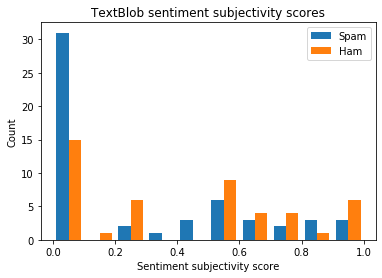

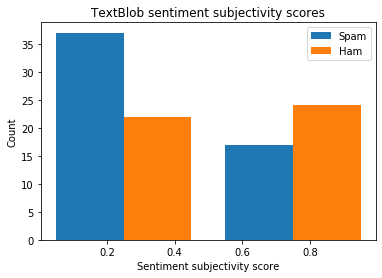

In [26]:
spam_subjectivities = [
    textblob_sentiment(x).subjectivity for _, x in df_dev.iterrows() if x.label == SPAM
]

ham_subjectivities = [
    textblob_sentiment(x).subjectivity for _, x in df_dev.iterrows() if x.label == HAM
]

plt.hist([spam_subjectivities, ham_subjectivities])
plt.title("TextBlob sentiment subjectivity scores")
plt.xlabel("Sentiment subjectivity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

plt.hist([spam_subjectivities, ham_subjectivities], bins=[0, 0.5, 1])
plt.title("TextBlob sentiment subjectivity scores")
plt.xlabel("Sentiment subjectivity score")
plt.ylabel("Count")
plt.legend(["Spam", "Ham"])
plt.show()

It looks like subjectivity scores above 0.5 will work pretty well for identifying `HAM` comments, though not perfectly.
We'll rely on our label model to learn that this is a lower accuracy rule.

In [27]:
@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    return HAM if x.subjectivity >= 0.5 else ABSTAIN

Let's apply our LFs so we can analyze their performance.

In [28]:
lfs = [textblob_polarity, textblob_subjectivity]

applier = PandasLFApplier(lfs)
L_train = applier.apply(df_train)
L_dev = applier.apply(df_dev)

  0%|          | 0/1586 [00:00<?, ?it/s]

  7%|▋         | 109/1586 [00:00<00:01, 1085.16it/s]

 14%|█▎        | 218/1586 [00:00<00:01, 1083.87it/s]

 21%|██        | 329/1586 [00:00<00:01, 1089.75it/s]

 28%|██▊       | 437/1586 [00:00<00:01, 1084.47it/s]

 34%|███▍      | 543/1586 [00:00<00:00, 1074.81it/s]

 41%|████      | 653/1586 [00:00<00:00, 1080.57it/s]

 48%|████▊     | 762/1586 [00:00<00:00, 1082.99it/s]

 54%|█████▍    | 862/1586 [00:00<00:00, 831.42it/s] 

 62%|██████▏   | 976/1586 [00:00<00:00, 903.16it/s]

 69%|██████▊   | 1089/1586 [00:01<00:00, 959.56it/s]

 76%|███████▌  | 1199/1586 [00:01<00:00, 997.49it/s]

 82%|████████▏ | 1307/1586 [00:01<00:00, 1020.28it/s]

 90%|████████▉ | 1422/1586 [00:01<00:00, 1055.63it/s]

 97%|█████████▋| 1531/1586 [00:01<00:00, 1063.35it/s]

100%|██████████| 1586/1586 [00:01<00:00, 1028.90it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 14282.37it/s]

In [29]:
LFAnalysis(L_train, lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,[0],0.035309,0.013871,0.0
textblob_subjectivity,1,[0],0.357503,0.013871,0.0


In [30]:
LFAnalysis(L_dev, lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
textblob_polarity,0,[0],0.05,0.02,0.0,4,1,0.800000
textblob_subjectivity,1,[0],0.41,0.02,0.0,24,17,0.585366


Again, these LFs aren't perfect, so we'll rely on our label model to denoise and resolve their outputs.

## 3. Writing More Labeling Functions

If a single LF had high enough coverage to label our entire test dataset accurately, then we wouldn't need a classifier at all.
We could just use that single simple heuristic to complete the task.
But most problems are not that simple.
Instead, we usually need to **combine multiple LFs** to label our dataset, both to increase the size of the generated training set (since we can't generate training labels for data points that all LFs abstained on) and to improve the overall accuracy of the training labels we generate by factoring in multiple different signals.

In the following sections, we'll show just a few of the many types of LFs that you could write to generate a training dataset for this problem.

### a) Keyword LFs

For text applications, some of the simplest LFs to write are often just keyword lookups.
These will often follow the same execution pattern, so we can create a template and use the `resources` parameter to pass in LF-specific keywords.
Similar to the [`labeling_function` decorator](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.labeling_function.html#snorkel.labeling.labeling_function),
the [`LabelingFunction` class](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LabelingFunction.html#snorkel.labeling.LabelingFunction)
wraps a Python function (the `f` parameter), and we can use the `resources` parameter to pass in keyword arguments (here, our keywords to lookup) to said function.

In [31]:
from snorkel.labeling import LabelingFunction


def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=SPAM):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )


"""Spam comments talk about 'my channel', 'my video', etc."""
keyword_my = make_keyword_lf(keywords=["my"])

"""Spam comments ask users to subscribe to their channels."""
keyword_subscribe = make_keyword_lf(keywords=["subscribe"])

"""Spam comments post links to other channels."""
keyword_link = make_keyword_lf(keywords=["http"])

"""Spam comments make requests rather than commenting."""
keyword_please = make_keyword_lf(keywords=["please", "plz"])

"""Ham comments actually talk about the video's content."""
keyword_song = make_keyword_lf(keywords=["song"], label=HAM)

### b) Pattern-matching LFs (regular expressions)

If we want a little more control over a keyword search, we can look for regular expressions instead.
The LF we developed above (`regex_check_out`) is an example of this.

### c)  Heuristic LFs

There may other heuristics or "rules of thumb" that you come up with as you look at the data.
So long as you can express it in a function, it's a viable LF!

In [32]:
@labeling_function()
def short_comment(x):
    """Ham comments are often short, such as 'cool video!'"""
    return HAM if len(x.text.split()) < 5 else ABSTAIN

### d) LFs with Complex Preprocessors

Some LFs rely on fields that aren't present in the raw data, but can be derived from it.
We can enrich our data (providing more fields for the LFs to refer to) using `Preprocessor`s.

For example, we can use the fantastic NLP (natural language processing) tool [spaCy](https://spacy.io/) to add lemmas, part-of-speech (pos) tags, etc. to each token.
Snorkel provides a prebuilt preprocessor for spaCy called `SpacyPreprocessor` which adds a new field to the
data point containing a [spaCy `Doc` object](https://spacy.io/api/doc).
For more info, see the [`SpacyPreprocessor` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.nlp.SpacyPreprocessor.html#snorkel.preprocess.nlp.SpacyPreprocessor).


If you prefer to use a different NLP tool, you can also wrap that as a `Preprocessor` and use it in the same way.
For more info, see the [`preprocessor` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/preprocess/snorkel.preprocess.preprocessor.html#snorkel.preprocess.preprocessor).

If the spaCy English model wasn't already installed, the next cell may raise an exception.
If this happens, restart the kernel and re-execute the cells up to this point.

In [33]:
from snorkel.preprocess.nlp import SpacyPreprocessor

# The SpacyPreprocessor parses the text in text_field and
# stores the new enriched representation in doc_field
spacy = SpacyPreprocessor(text_field="text", doc_field="doc", memoize=True)

In [34]:
@labeling_function(pre=[spacy])
def has_person(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

Because spaCy is such a common preprocessor for NLP applications, we also provide a
[prebuilt `labeling_function`-like decorator that uses spaCy](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.lf.nlp.nlp_labeling_function.html#snorkel.labeling.lf.nlp.nlp_labeling_function).
This resulting LF is identical to the one defined manually above.

In [35]:
from snorkel.labeling.lf.nlp import nlp_labeling_function


@nlp_labeling_function()
def has_person_nlp(x):
    """Ham comments mention specific people and are short."""
    if len(x.doc) < 20 and any([ent.label_ == "PERSON" for ent in x.doc.ents]):
        return HAM
    else:
        return ABSTAIN

**Adding new domain-specific preprocessors and LF types is a great way to contribute to Snorkel!
If you have an idea, feel free to reach out to the maintainers or submit a PR!**

### e) Third-party Model LFs

We can also utilize other models, including ones trained for other tasks that are related to, but not the same as, the one we care about.
The TextBlob-based LFs we created above are great examples of this!

## 4. Combining Labeling Function Outputs with the Label Model

This tutorial demonstrates just a handful of the types of LFs that one might write for this task.
Many of these are no doubt suboptimal.
The strength of this approach, however, is that the LF abstraction provides a flexible interface for conveying a huge variety of supervision signals, and the `LabelModel` is able to denoise these signals, reducing the need for painstaking manual fine-tuning.

In [36]:
lfs = [
    keyword_my,
    keyword_subscribe,
    keyword_link,
    keyword_please,
    keyword_song,
    regex_check_out,
    short_comment,
    has_person_nlp,
    textblob_polarity,
    textblob_subjectivity,
]

With our full set of LFs, we can now apply these once again with `LFApplier` to get our the label matrices for the `train` and `dev` splits.
We'll use the `train` split's label matrix to generate training labels with the Label Model.
The `dev` split's label model is primarily helpful for looking at summary statistics.

The Pandas format provides an easy interface that many practioners are familiar with, but it is also less optimized for scale.
For larger datasets, more compute-intensive LFs, or larger LF sets, you may decide to use one of the other data formats
that Snorkel supports natively, such as Dask DataFrames or PySpark DataFrames, and their corresponding applier objects.
For more info, check out the [Snorkel API documentation](https://snorkel.readthedocs.io/en/master/packages/labeling.html).

In [37]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=df_train)
L_dev = applier.apply(df=df_dev)
L_valid = applier.apply(df=df_valid)

  0%|          | 0/1586 [00:00<?, ?it/s]

  1%|          | 13/1586 [00:00<00:12, 129.00it/s]

  2%|▏         | 25/1586 [00:00<00:12, 122.08it/s]

  2%|▏         | 36/1586 [00:00<00:13, 115.91it/s]

  3%|▎         | 49/1586 [00:00<00:13, 117.24it/s]

  4%|▍         | 63/1586 [00:00<00:12, 121.39it/s]

  5%|▍         | 76/1586 [00:00<00:12, 122.07it/s]

  6%|▌         | 89/1586 [00:00<00:12, 122.94it/s]

  6%|▋         | 102/1586 [00:00<00:11, 124.06it/s]

  7%|▋         | 114/1586 [00:00<00:12, 118.78it/s]

  8%|▊         | 126/1586 [00:01<00:12, 118.86it/s]

  9%|▉         | 139/1586 [00:01<00:11, 120.79it/s]

 10%|▉         | 152/1586 [00:01<00:11, 121.73it/s]

 10%|█         | 166/1586 [00:01<00:11, 123.87it/s]

 11%|█▏        | 179/1586 [00:01<00:12, 112.97it/s]

 12%|█▏        | 191/1586 [00:01<00:12, 113.31it/s]

 13%|█▎        | 204/1586 [00:01<00:11, 116.04it/s]

 14%|█▎        | 217/1586 [00:01<00:11, 119.45it/s]

 15%|█▍        | 230/1586 [00:01<00:11, 120.72it/s]

 15%|█▌        | 243/1586 [00:02<00:11, 121.67it/s]

 16%|█▌        | 256/1586 [00:02<00:11, 120.53it/s]

 17%|█▋        | 269/1586 [00:02<00:10, 120.27it/s]

 18%|█▊        | 282/1586 [00:02<00:10, 120.79it/s]

 19%|█▊        | 295/1586 [00:02<00:10, 120.61it/s]

 19%|█▉        | 308/1586 [00:02<00:11, 114.37it/s]

 20%|██        | 322/1586 [00:02<00:10, 119.32it/s]

 21%|██        | 335/1586 [00:02<00:10, 117.41it/s]

 22%|██▏       | 349/1586 [00:02<00:10, 122.80it/s]

 23%|██▎       | 362/1586 [00:03<00:10, 121.44it/s]

 24%|██▎       | 375/1586 [00:03<00:10, 116.10it/s]

 24%|██▍       | 388/1586 [00:03<00:10, 118.66it/s]

 25%|██▌       | 400/1586 [00:03<00:10, 110.35it/s]

 26%|██▌       | 413/1586 [00:03<00:10, 113.75it/s]

 27%|██▋       | 425/1586 [00:03<00:10, 114.29it/s]

 28%|██▊       | 437/1586 [00:03<00:10, 113.56it/s]

 28%|██▊       | 450/1586 [00:03<00:09, 116.34it/s]

 29%|██▉       | 462/1586 [00:03<00:09, 114.33it/s]

 30%|██▉       | 474/1586 [00:04<00:10, 111.00it/s]

 31%|███       | 486/1586 [00:04<00:10, 108.05it/s]

 31%|███▏      | 497/1586 [00:04<00:10, 106.61it/s]

 32%|███▏      | 510/1586 [00:04<00:09, 110.67it/s]

 33%|███▎      | 522/1586 [00:04<00:09, 108.52it/s]

 34%|███▎      | 533/1586 [00:04<00:09, 107.36it/s]

 34%|███▍      | 544/1586 [00:04<00:09, 106.97it/s]

 35%|███▌      | 557/1586 [00:04<00:09, 112.33it/s]

 36%|███▌      | 569/1586 [00:04<00:09, 112.57it/s]

 37%|███▋      | 582/1586 [00:04<00:08, 116.80it/s]

 37%|███▋      | 594/1586 [00:05<00:08, 115.44it/s]

 38%|███▊      | 607/1586 [00:05<00:08, 119.22it/s]

 39%|███▉      | 619/1586 [00:05<00:08, 116.34it/s]

 40%|███▉      | 631/1586 [00:05<00:08, 116.94it/s]

 41%|████      | 643/1586 [00:05<00:08, 111.03it/s]

 41%|████▏     | 655/1586 [00:05<00:08, 106.46it/s]

 42%|████▏     | 667/1586 [00:05<00:08, 108.54it/s]

 43%|████▎     | 678/1586 [00:05<00:08, 106.49it/s]

 44%|████▎     | 690/1586 [00:05<00:08, 109.69it/s]

 44%|████▍     | 702/1586 [00:06<00:07, 111.79it/s]

 45%|████▌     | 716/1586 [00:06<00:07, 116.98it/s]

 46%|████▌     | 729/1586 [00:06<00:07, 119.10it/s]

 47%|████▋     | 741/1586 [00:06<00:07, 117.85it/s]

 48%|████▊     | 754/1586 [00:06<00:06, 120.70it/s]

 48%|████▊     | 768/1586 [00:06<00:06, 125.27it/s]

 49%|████▉     | 782/1586 [00:06<00:06, 128.75it/s]

 50%|█████     | 795/1586 [00:06<00:06, 125.31it/s]

 51%|█████     | 808/1586 [00:06<00:06, 124.79it/s]

 52%|█████▏    | 822/1586 [00:07<00:05, 128.73it/s]

 53%|█████▎    | 837/1586 [00:07<00:05, 132.58it/s]

 54%|█████▎    | 851/1586 [00:07<00:05, 134.24it/s]

 55%|█████▍    | 866/1586 [00:07<00:05, 135.05it/s]

 55%|█████▌    | 880/1586 [00:07<00:05, 136.29it/s]

 56%|█████▋    | 894/1586 [00:07<00:05, 134.54it/s]

 57%|█████▋    | 908/1586 [00:07<00:05, 135.52it/s]

 58%|█████▊    | 922/1586 [00:07<00:04, 134.89it/s]

 59%|█████▉    | 936/1586 [00:07<00:05, 124.08it/s]

 60%|█████▉    | 950/1586 [00:07<00:05, 127.06it/s]

 61%|██████    | 963/1586 [00:08<00:04, 127.40it/s]

 62%|██████▏   | 976/1586 [00:08<00:04, 124.46it/s]

 62%|██████▏   | 990/1586 [00:08<00:04, 126.09it/s]

 63%|██████▎   | 1004/1586 [00:08<00:04, 129.33it/s]

 64%|██████▍   | 1017/1586 [00:08<00:04, 126.94it/s]

 65%|██████▌   | 1031/1586 [00:08<00:04, 128.33it/s]

 66%|██████▌   | 1044/1586 [00:08<00:04, 122.89it/s]

 67%|██████▋   | 1058/1586 [00:08<00:04, 125.96it/s]

 68%|██████▊   | 1072/1586 [00:08<00:04, 127.70it/s]

 68%|██████▊   | 1085/1586 [00:09<00:04, 123.51it/s]

 69%|██████▉   | 1099/1586 [00:09<00:03, 125.22it/s]

 70%|███████   | 1112/1586 [00:09<00:03, 119.08it/s]

 71%|███████   | 1126/1586 [00:09<00:03, 123.74it/s]

 72%|███████▏  | 1141/1586 [00:09<00:03, 127.53it/s]

 73%|███████▎  | 1154/1586 [00:09<00:03, 127.88it/s]

 74%|███████▎  | 1167/1586 [00:09<00:03, 122.61it/s]

 74%|███████▍  | 1180/1586 [00:09<00:03, 121.53it/s]

 75%|███████▌  | 1193/1586 [00:09<00:03, 123.62it/s]

 76%|███████▌  | 1206/1586 [00:10<00:03, 118.10it/s]

 77%|███████▋  | 1220/1586 [00:10<00:02, 122.43it/s]

 78%|███████▊  | 1233/1586 [00:10<00:02, 122.80it/s]

 79%|███████▊  | 1246/1586 [00:10<00:02, 116.91it/s]

 79%|███████▉  | 1258/1586 [00:10<00:02, 116.68it/s]

 80%|████████  | 1270/1586 [00:10<00:02, 117.42it/s]

 81%|████████  | 1282/1586 [00:10<00:02, 117.56it/s]

 82%|████████▏ | 1294/1586 [00:10<00:02, 114.33it/s]

 82%|████████▏ | 1306/1586 [00:10<00:02, 108.19it/s]

 83%|████████▎ | 1318/1586 [00:11<00:02, 110.22it/s]

 84%|████████▍ | 1331/1586 [00:11<00:02, 113.96it/s]

 85%|████████▍ | 1344/1586 [00:11<00:02, 118.27it/s]

 85%|████████▌ | 1356/1586 [00:11<00:01, 118.07it/s]

 86%|████████▋ | 1368/1586 [00:11<00:01, 118.58it/s]

 87%|████████▋ | 1380/1586 [00:11<00:01, 115.72it/s]

 88%|████████▊ | 1394/1586 [00:11<00:01, 119.98it/s]

 89%|████████▉ | 1408/1586 [00:11<00:01, 123.18it/s]

 90%|████████▉ | 1421/1586 [00:11<00:01, 123.84it/s]

 90%|█████████ | 1434/1586 [00:12<00:01, 88.79it/s] 

 91%|█████████ | 1445/1586 [00:12<00:01, 92.18it/s]

 92%|█████████▏| 1458/1586 [00:12<00:01, 98.11it/s]

 93%|█████████▎| 1470/1586 [00:12<00:01, 102.70it/s]

 93%|█████████▎| 1482/1586 [00:12<00:00, 106.35it/s]

 94%|█████████▍| 1494/1586 [00:12<00:00, 102.20it/s]

 95%|█████████▌| 1507/1586 [00:12<00:00, 108.62it/s]

 96%|█████████▌| 1519/1586 [00:12<00:00, 107.21it/s]

 97%|█████████▋| 1533/1586 [00:12<00:00, 114.24it/s]

 97%|█████████▋| 1546/1586 [00:13<00:00, 117.75it/s]

 98%|█████████▊| 1559/1586 [00:13<00:00, 114.79it/s]

 99%|█████████▉| 1571/1586 [00:13<00:00, 115.81it/s]

100%|█████████▉| 1585/1586 [00:13<00:00, 117.66it/s]

100%|██████████| 1586/1586 [00:13<00:00, 118.05it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 13/100 [00:00<00:00, 124.72it/s]

 24%|██▍       | 24/100 [00:00<00:00, 117.87it/s]

 38%|███▊      | 38/100 [00:00<00:00, 121.85it/s]

 52%|█████▏    | 52/100 [00:00<00:00, 122.69it/s]

 64%|██████▍   | 64/100 [00:00<00:00, 119.76it/s]

 75%|███████▌  | 75/100 [00:00<00:00, 115.83it/s]

 88%|████████▊ | 88/100 [00:00<00:00, 118.00it/s]

100%|██████████| 100/100 [00:00<00:00, 118.56it/s]


  0%|          | 0/120 [00:00<?, ?it/s]

  8%|▊         | 9/120 [00:00<00:01, 87.71it/s]

 16%|█▌        | 19/120 [00:00<00:01, 90.19it/s]

 24%|██▍       | 29/120 [00:00<00:01, 90.32it/s]

 32%|███▎      | 39/120 [00:00<00:00, 91.79it/s]

 40%|████      | 48/120 [00:00<00:00, 89.65it/s]

 51%|█████     | 61/120 [00:00<00:00, 97.38it/s]

 60%|██████    | 72/120 [00:00<00:00, 99.35it/s]

 70%|███████   | 84/120 [00:00<00:00, 102.26it/s]

 81%|████████  | 97/120 [00:00<00:00, 107.44it/s]

 91%|█████████ | 109/120 [00:01<00:00, 110.79it/s]

100%|██████████| 120/120 [00:01<00:00, 103.71it/s]

In [38]:
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(Y=Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_my,0,[1],0.22,0.22,0.14,19,3,0.863636
keyword_subscribe,1,[1],0.14,0.12,0.06,14,0,1.000000
keyword_http,2,[1],0.10,0.08,0.07,10,0,1.000000
keyword_please,3,[1],0.10,0.10,0.06,10,0,1.000000
keyword_song,4,[0],0.16,0.12,0.06,11,5,0.687500
regex_check_out,5,[1],0.29,0.22,0.17,29,0,1.000000
short_comment,6,[0],0.28,0.20,0.07,19,9,0.678571
has_person_nlp,7,[0],0.15,0.13,0.04,10,5,0.666667
textblob_polarity,8,[0],0.05,0.05,0.01,4,1,0.800000
textblob_subjectivity,9,[0],0.41,0.34,0.20,24,17,0.585366


We see that our labeling functions vary in coverage, accuracy, and how much they overlap/conflict with one another.
We can view a histogram of how many LF labels the data points in our dev set have to get an idea of our total coverage.

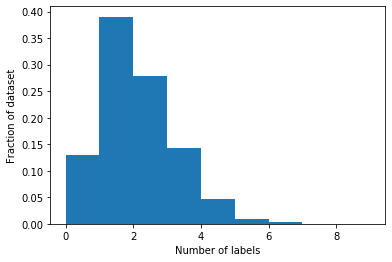

In [39]:
def plot_label_frequency(L):
    plt.hist((L != ABSTAIN).sum(axis=1), density=True, bins=range(L.shape[1]))
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)

We see that over half of our `train` dataset data points have 2 or fewer labels from LFs.
Fortunately, the signal we do have can be used to train a classifier over the comment text directly, allowing it to generalize beyond what we've specified via our LFs.

Our goal is now to convert the labels from our LFs into a single _noise-aware_ probabilistic (or confidence-weighted) label per data point.
A simple baseline for doing this is to take the majority vote on a per-data point basis: if more LFs voted SPAM than HAM, label it SPAM (and vice versa).
We can test this with the
[`MajorityLabelVoter` baseline model](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.MajorityLabelVoter.html#snorkel.labeling.MajorityLabelVoter).

In [40]:
from snorkel.labeling import MajorityLabelVoter

majority_model = MajorityLabelVoter()
preds_train = majority_model.predict(L=L_train)

In [41]:
preds_train

array([ 1,  1, -1, ...,  1,  1,  1])

However, as we can clearly see by looking the summary statistics of our LFs in the previous section, they are not all equally accurate, and should not be treated identically. In addition to having varied accuracies and coverages, LFs may be correlated, resulting in certain signals being overrepresented in a majority-vote-based model. To handle these issues appropriately, we will instead use a more sophisticated Snorkel `LabelModel` to combine the outputs of the LFs.

This model will ultimately produce a single set of noise-aware training labels, which are probabilistic or confidence-weighted labels. We will then use these labels to train a classifier for our task. For more technical details of this overall approach, see our [NeurIPS 2016](https://arxiv.org/abs/1605.07723) and [AAAI 2019](https://arxiv.org/abs/1810.02840) papers. For more info on the API, see the [`LabelModel` documentation](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.LabelModel.html#snorkel.labeling.LabelModel).

Note that no gold labels are used during the training process.
The only information we need is the label matrix, which contains the output of the LFs on our training set.
The `LabelModel` is able to learn weights for the labeling functions using only the label matrix as input.
We also specify the `cardinality`, or number of classes.
The `LabelModel` trains much more quickly than typical discriminative models since we only need the label matrix as input.

In [42]:
from snorkel.labeling import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, lr=0.001, log_freq=100, seed=123)

In [43]:
majority_acc = majority_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

label_model_acc = label_model.score(L=L_valid, Y=Y_valid)["accuracy"]
print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

Majority Vote Accuracy:   91.5%
Label Model Accuracy:     92.4%


So our `LabelModel` improves over the majority vote baseline!
However, it is typically **not suitable as an inference-time model** to make predictions for unseen data points, due to (among other things) some data points having all abstain labels.
In the next section, we will use the output of the label model as  training labels to train a
discriminative classifier to see if we can improve performance further.
This classifier will only need the text of the comment to make predictions, making it much more suitable
for inference over unseen comments.
For more information on the properties of the label model and when to use it, see the [Snorkel guides]().

We can also run error analysis after the label model has been trained.
For example, let's take a look at 5 random false negatives from the `dev` set, which might inspire some more LFs that vote `SPAM`.

In [44]:
probs_dev = majority_model.predict_proba(L=L_dev)
preds_dev = probs_dev >= 0.5
buckets = get_label_buckets(Y_dev, preds_dev[:, 1])

df_fn_dev = df_dev[["text", "label"]].iloc[buckets[(SPAM, HAM)]]
df_fn_dev["probability"] = probs_dev[buckets[(SPAM, HAM)], 1]

df_fn_dev.sample(5, random_state=3)

,text,label,probability
195,Check Out The New Hot Video By Dante B Called ...,1,0.0
334,Check out Em&#39;s dope new song monster here:...,1,0.0
431,CHECK OUT Eminem - Rap God LYRIC VIDEO,1,0.0
313,Aslamu Lykum... From Pakistan﻿,1,0.0
189,/watch?v=aImbWbfQbzg watch and subscrible,1,0.0


Let's briefly confirm that the labels the `LabelModel` produces are probabilistic in nature.
The following histogram shows the confidences we have that each data point has the label SPAM.
The points we are least certain about will have labels close to 0.5.

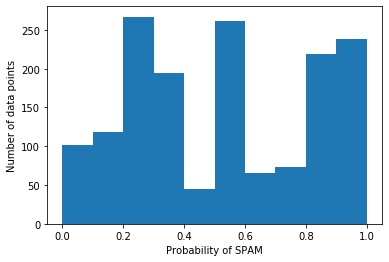

In [45]:
def plot_probabilities_histogram(Y):
    plt.hist(Y, bins=10)
    plt.xlabel("Probability of SPAM")
    plt.ylabel("Number of data points")
    plt.show()


probs_train = label_model.predict_proba(L=L_train)
plot_probabilities_histogram(probs_train[:, SPAM])

### Filtering out unlabeled data points

As we saw earlier, some of the data points in our `train` set received no labels from any of our LFs.
These data points convey no supervision signal and tend to hurt performance, so we filter them out before training using a
[built-in utility](https://snorkel.readthedocs.io/en/master/packages/_autosummary/labeling/snorkel.labeling.filter_unlabeled_dataframe.html#snorkel.labeling.filter_unlabeled_dataframe).

In [46]:
from snorkel.labeling import filter_unlabeled_dataframe

df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
    X=df_train, y=probs_train, L=L_train
)

## 5. Training a Classifier

In this final section of the tutorial, we'll use the noisy training labels we generated in the last section to train a classifier for our task.
**The output of the Snorkel `LabelModel` is just a set of labels which can be used with most popular libraries for performing supervised learning, such as TensorFlow, Keras, PyTorch, Scikit-Learn, Ludwig, and XGBoost.**
In this tutorial, we demonstrate using classifiers from [Keras](https://keras.io) and [Scikit-Learn](https://scikit-learn.org).

### Featurization

For simplicity and speed, we use a simple "bag of n-grams" feature representation: each data point is represented by a one-hot vector marking which words or 2-word combinations are present in the comment text.

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train = vectorizer.fit_transform(df_train_filtered.text.tolist())

X_dev = vectorizer.transform(df_dev.text.tolist())
X_valid = vectorizer.transform(df_valid.text.tolist())
X_test = vectorizer.transform(df_test.text.tolist())

### Keras Classifier with Probabilistic Labels

We'll use Keras, a popular high-level API for building models in TensorFlow, to build a simple logistic regression classifier.
We compile it with a `categorical_crossentropy` loss so that it can handle probabilistic labels instead of integer labels.
Using a _noise-aware loss_ &mdash; one that uses probabilistic labels &mdash; for our discriminative model lets
us take full advantage of the label model's learning procedure (see our [NeurIPS 2016 paper](https://arxiv.org/abs/1605.07723)).
We use the common settings of an `Adam` optimizer and early stopping (evaluating the model on the validation set after each epoch and reloading the weights from when it achieved the best score).
For more information on Keras, see the [Keras documentation](https://keras.io/).

This next cell makes our Keras results reproducible. You can ignore it.

In [48]:
import random

import numpy as np
import tensorflow as tf


seed = 1
np.random.seed(seed)
random.seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)

from tensorflow.keras import backend as K

tf.set_random_seed(seed)
sess = tf.compat.v1.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [49]:
from snorkel.analysis import metric_score
from snorkel.utils import preds_to_probs
from utils import get_keras_logreg, get_keras_early_stopping

# Define a vanilla logistic regression model with Keras
keras_model = get_keras_logreg(input_dim=X_train.shape[1])

keras_model.fit(
    x=X_train,
    y=probs_train_filtered,
    validation_data=(X_valid, preds_to_probs(Y_valid, 2)),
    callbacks=[get_keras_early_stopping()],
    epochs=50,
    verbose=0,
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


In [50]:
preds_test = keras_model.predict(x=X_test).argmax(axis=1)
test_acc = metric_score(golds=Y_test, preds=preds_test, metric="accuracy")
print(f"Test Accuracy: {test_acc * 100:.1f}%")

Test Accuracy: 90.0%


**We observe an additional boost in accuracy over the `LabelModel` by multiple points!
By using the label model to transfer the domain knowledge encoded in our LFs to the discriminative model,
we were able to generalize beyond the noisy labeling heuristics**.

We can compare this to the score we could have gotten if we had used our small labeled `dev` set directly as training data instead of using it to guide the creation of LFs.

In [51]:
keras_dev_model = get_keras_logreg(input_dim=X_train.shape[1], output_dim=1)

keras_dev_model.fit(
    x=X_dev,
    y=Y_dev,
    validation_data=(X_valid, Y_valid),
    callbacks=[get_keras_early_stopping()],
    epochs=50,
    verbose=0,
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping


In [52]:
preds_test_dev = np.round(keras_dev_model.predict(x=X_test))
test_acc = metric_score(golds=Y_test, preds=preds_test_dev, metric="accuracy")
print(f"Test Accuracy: {test_acc * 100:.1f}%")

Test Accuracy: 89.6%


### Scikit-Learn with Rounded Labels

If we want to use a library or model that doesn't accept probabilistic labels, we can replace each label distribution with the label of the class that has the maximum probability.
This can easily be done using the
[`probs_to_preds` helper method](https://snorkel.readthedocs.io/en/master/packages/_autosummary/utils/snorkel.utils.probs_to_preds.html#snorkel.utils.probs_to_preds).
It's important to note that this transformation is lossy, as we no longer have values for our confidence in each label.

In [53]:
from snorkel.utils import probs_to_preds

preds_train_filtered = probs_to_preds(probs=probs_train_filtered)

For example, this allows us to use standard models from Scikit-Learn.

In [54]:
from sklearn.linear_model import LogisticRegression

sklearn_model = LogisticRegression(C=0.001, solver="liblinear")
sklearn_model.fit(X=X_train, y=preds_train_filtered)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
print(f"Test Accuracy: {sklearn_model.score(X=X_test, y=Y_test) * 100:.1f}%")

Test Accuracy: 92.8%


## Summary

In this tutorial, we accomplished the following:
* We introduced the concept of Labeling Functions (LFs) and demonstrated some of the forms they can take.
* We used the Snorkel `LabelModel` to automatically learn how to combine the outputs of our LFs into strong probabilistic labels.
* We showed that a classifier trained on a weakly supervised dataset can outperform an approach based on the LFs alone as it learns to generalize beyond the noisy heuristics we provide.

### Next Steps

If you enjoyed this tutorial and you've already checked out the [Getting Started](https://snorkel.org/get-started/) tutorial, check out the [Tutorials](https://snorkel.org/use-cases/) page for other tutorials that you may find interesting, including demonstrations of how to use Snorkel

* As part of a [hybrid crowdsourcing pipeline](https://snorkel.org/use-cases/crowdsourcing-tutorial)
* For [visual relationship detection over images](https://snorkel.org/use-cases/visual-relation-tutorial)
* For [information extraction over text](https://snorkel.org/use-cases/spouse-demo)
* For [data augmentation](https://snorkel.org/use-cases/02-spam-data-augmentation-tutorial)

and more!
You can also visit the [Snorkel website](https://snorkel.org) or [Snorkel API documentation](https://snorkel.readthedocs.io) for more info!